In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/yelp-nyc-fe/yelp_NYC_2_0.csv


# Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, auc, roc_auc_score, classification_report
# from imblearn.under_sampling import ClusterCentroids
from sklearn.decomposition import PCA

import scipy as sp

import cupy
import cuml
import cudf

!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'Times New Roman'

# Датасет

In [4]:
df_origin = cudf.read_csv('/kaggle/input/yelp-nyc-fe/yelp_NYC_2_0.csv')
df_origin

,Unnamed: 0,user_id,prod_id,review,rating,label,prod_name,date,avg_prod_rating,avg_user_rating,review_len,cnt_reviews,neg,neu,pos,compound,cap_words,digit_words
0,0,1133,1,My wife and I took my parents there for lunch ...,1.0,-1,Peppino’s,2013-12-21,4.33,1.00,553,1,0.106,0.722,0.172,0.8431,0,0
1,1,1134,1,Got a margarita pizza. First off let me say ve...,1.0,-1,Peppino’s,2013-11-25,4.33,1.00,305,1,0.112,0.813,0.075,-0.5160,1,1
2,2,1135,1,The food is average pizzeria and not cheap. A...,2.0,-1,Peppino’s,2014-07-24,4.33,3.25,157,8,0.085,0.915,0.000,-0.4215,0,0
3,3,1136,1,I can not fathom why people would give this re...,2.0,-1,Peppino’s,2014-03-05,4.33,2.00,766,1,0.027,0.878,0.096,0.8743,0,0
4,4,1137,1,Went here during the time it was busy and i go...,3.0,-1,Peppino’s,2014-11-21,4.33,3.00,185,1,0.000,1.000,0.000,0.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358742,358742,161146,349,"I'm very spoiled with Pizza. Really, I have tr...",5.0,1,Emily,2014-02-06,4.19,5.00,1441,1,0.000,0.798,0.202,0.9949,1,1
358743,358743,116424,349,Can't say enough good things about this place....,5.0,1,Emily,2014-01-31,4.19,5.00,475,2,0.043,0.642,0.316,0.9829,0,0
358744,358744,161147,349,"Had a great dinner here- fantastic pizza, the ...",5.0,1,Emily,2014-01-30,4.19,5.00,268,1,0.000,0.605,0.395,0.9788,0,0
358745,358745,97930,349,"Great foods and great drinks, they have even p...",5.0,1,Emily,2014-01-25,4.19,5.00,150,2,0.000,0.474,0.526,0.9682,0,0


In [5]:
df = df_origin.copy()
df

,Unnamed: 0,user_id,prod_id,review,rating,label,prod_name,date,avg_prod_rating,avg_user_rating,review_len,cnt_reviews,neg,neu,pos,compound,cap_words,digit_words
0,0,1133,1,My wife and I took my parents there for lunch ...,1.0,-1,Peppino’s,2013-12-21,4.33,1.00,553,1,0.106,0.722,0.172,0.8431,0,0
1,1,1134,1,Got a margarita pizza. First off let me say ve...,1.0,-1,Peppino’s,2013-11-25,4.33,1.00,305,1,0.112,0.813,0.075,-0.5160,1,1
2,2,1135,1,The food is average pizzeria and not cheap. A...,2.0,-1,Peppino’s,2014-07-24,4.33,3.25,157,8,0.085,0.915,0.000,-0.4215,0,0
3,3,1136,1,I can not fathom why people would give this re...,2.0,-1,Peppino’s,2014-03-05,4.33,2.00,766,1,0.027,0.878,0.096,0.8743,0,0
4,4,1137,1,Went here during the time it was busy and i go...,3.0,-1,Peppino’s,2014-11-21,4.33,3.00,185,1,0.000,1.000,0.000,0.0000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358742,358742,161146,349,"I'm very spoiled with Pizza. Really, I have tr...",5.0,1,Emily,2014-02-06,4.19,5.00,1441,1,0.000,0.798,0.202,0.9949,1,1
358743,358743,116424,349,Can't say enough good things about this place....,5.0,1,Emily,2014-01-31,4.19,5.00,475,2,0.043,0.642,0.316,0.9829,0,0
358744,358744,161147,349,"Had a great dinner here- fantastic pizza, the ...",5.0,1,Emily,2014-01-30,4.19,5.00,268,1,0.000,0.605,0.395,0.9788,0,0
358745,358745,97930,349,"Great foods and great drinks, they have even p...",5.0,1,Emily,2014-01-25,4.19,5.00,150,2,0.000,0.474,0.526,0.9682,0,0


# Предобработка

In [6]:
# функция предобработки текста
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_review(text):
    cl_text = text.lower().strip()
    cl_text = re.sub(r"[^\w\s]", "", cl_text)
    words = word_tokenize(cl_text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

example = 'this is the (test) example for preprocessing function 123 8done 8 :!?!'
print(preprocess_review(example))

test example preprocessing function 123 8done 8


In [7]:
df= df.drop(['Unnamed: 0', 'user_id',	'prod_id', 'date', 'compound', 'prod_name'], axis=1)
df

,review,rating,label,avg_prod_rating,avg_user_rating,review_len,cnt_reviews,neg,neu,pos,cap_words,digit_words
0,My wife and I took my parents there for lunch ...,1.0,-1,4.33,1.00,553,1,0.106,0.722,0.172,0,0
1,Got a margarita pizza. First off let me say ve...,1.0,-1,4.33,1.00,305,1,0.112,0.813,0.075,1,1
2,The food is average pizzeria and not cheap. A...,2.0,-1,4.33,3.25,157,8,0.085,0.915,0.000,0,0
3,I can not fathom why people would give this re...,2.0,-1,4.33,2.00,766,1,0.027,0.878,0.096,0,0
4,Went here during the time it was busy and i go...,3.0,-1,4.33,3.00,185,1,0.000,1.000,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
358742,"I'm very spoiled with Pizza. Really, I have tr...",5.0,1,4.19,5.00,1441,1,0.000,0.798,0.202,1,1
358743,Can't say enough good things about this place....,5.0,1,4.19,5.00,475,2,0.043,0.642,0.316,0,0
358744,"Had a great dinner here- fantastic pizza, the ...",5.0,1,4.19,5.00,268,1,0.000,0.605,0.395,0,0
358745,"Great foods and great drinks, they have even p...",5.0,1,4.19,5.00,150,2,0.000,0.474,0.526,0,0


In [8]:
df_cpu = df.to_pandas()

In [9]:
df_cpu['review'] = df_cpu['review'].apply(preprocess_review)

In [10]:
df = cudf.from_pandas(df_cpu)
df

,review,rating,label,avg_prod_rating,avg_user_rating,review_len,cnt_reviews,neg,neu,pos,cap_words,digit_words
0,wife took parent lunch greeted stare staff gre...,1.0,-1,4.33,1.00,553,1,0.106,0.722,0.172,0,0
1,got margarita pizza first let say expensive on...,1.0,-1,4.33,1.00,305,1,0.112,0.813,0.075,1,1
2,food average pizzeria cheap add fact puked gut...,2.0,-1,4.33,3.25,157,8,0.085,0.915,0.000,0,0
3,fathom people would give restaurant star two i...,2.0,-1,4.33,2.00,766,1,0.027,0.878,0.096,0,0
4,went time busy got regular slice received warm...,3.0,-1,4.33,3.00,185,1,0.000,1.000,0.000,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
358742,im spoiled pizza really tried lucalis di faras...,5.0,1,4.19,5.00,1441,1,0.000,0.798,0.202,1,1
358743,cant say enough good thing place stopped last ...,5.0,1,4.19,5.00,475,2,0.043,0.642,0.316,0,0
358744,great dinner fantastic pizza smore pizza desse...,5.0,1,4.19,5.00,268,1,0.000,0.605,0.395,0,0
358745,great food great drink even pairing wine pizza...,5.0,1,4.19,5.00,150,2,0.000,0.474,0.526,0,0


# Методы визуализации метрик

In [11]:
def show_metrics(y_true, y_pred, title):
    print(f'''
                {title}
==========================================
 auc: {roc_auc_score(y_true, y_pred)}             
==========================================
 report:                                
{classification_report(y_true, y_pred)}
==========================================

    ''')

In [12]:
def show_confusion_matrix(y_true, y_pred, title_string):
    conf = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,8))
    plt.title(title_string)
    sns.heatmap(conf, fmt='d', annot=True)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()

In [13]:
from sklearn.metrics import (
    roc_auc_score, 
    accuracy_score, 
    precision_score,
    recall_score, 
    f1_score, 
    classification_report,
    confusion_matrix,
    average_precision_score
)

def show_classification_report(y_true, y_pred):
    """
    Выводит основные метрики классификации в консоль
    
    Параметры:
    y_true - истинные метки
    y_pred - предсказанные метки
    """
    y_test_numpy, y_pred_numpy = cupy.asnumpy(y_true), cupy.asnumpy(y_pred)
    
    # Вычисляем метрики
    accuracy = accuracy_score(y_test_numpy, y_pred_numpy)
    precision = precision_score(y_test_numpy, y_pred_numpy)
    recall = recall_score(y_test_numpy, y_pred_numpy)
    f1 = f1_score(y_test_numpy, y_pred_numpy)
    roc_auc = roc_auc_score(y_test_numpy, y_pred_numpy)  # Используем бинарные предсказания

    print(f'''
    Accuracy:{accuracy:.4f} 
    Precision:{precision:.4f}
    Recall:{recall:.4f}
    F1: {f1:.4f}
    AUC: {roc_auc:.4f}
    
    ''')


In [14]:
# show_metrics([1,0,1,1,0], [1,0,1,1,0],'test example')

In [15]:
# show_confusion_matrix([1,0,1,1,0], [1,0,1,1,0], 'test_example')

# TF-IDF векторизация

In [16]:
stop_words = stopwords.words('english')
temp = [preprocess_review(word) for word in stop_words]
stop_words = stop_words + [word for word in temp if word != '']
# print(stop_words)

In [17]:
from cuml.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), max_features=1000)
X_tfidf = vectorizer.fit_transform(df['review'])
y = df['label']
# review_vector_test = vectorizer.transform(x_test['review'])

In [18]:
print(type(X_tfidf),
      X_tfidf.shape,
      y.shape)

<class 'cupyx.scipy.sparse._csr.csr_matrix'> (358747, 1000) (358747,)


# Kmeans балансировка

In [19]:
from cuml import KMeans
from cuml.metrics import pairwise_distances
import cupy as cp

# Функция для андерсемплинга класса
def cluster_centroids_majority_KMeans(
    X_majority,
    y_majority,
    n_samples_per_cluster,
    n_clusters=3,
    n_init=10,
    max_iter=300,
):
    # Инициализация KMeans
    estimator = KMeans(n_clusters=n_clusters, random_state=42, max_iter=max_iter, n_init=n_init, verbose=True, )
    
    X_majority_df = cudf.DataFrame(X_majority.todense())  # Преобразуем в dense
    X_majority_df.index = y_majority.index #
    x_cupy = X_majority_df.to_cupy()  # Преобразуем в cupy
    print(f'X_cupy: {x_cupy}')
    print(f'X_cupy размерность: {x_cupy.shape}')
    
    print(f'Индексы X_majority_df: {X_majority_df.index}')
    print("---------------------------------")
    print(f'Индексы y: {y_majority.index}')
    print(f'''
    Размерности: 
      X: {X_majority_df.shape}
      y: {y_majority.shape}
      
    ''')
    print((X_majority_df.index == y_majority.index).sum())
    estimator.fit(x_cupy)
    
    cluster_labels = estimator.predict(x_cupy)  # Берем метки

    
    print(f'метки кластера: {cluster_labels}' )
    print(f'метки кластера размерность: {cluster_labels.shape}')
    print(f'метки кластера индексы: {cudf.Series(cluster_labels).index}')
    print(f'количество точек кластера 0 {(cluster_labels==0).sum()}')
    print(f'количество точек кластера 1 {(cluster_labels==1).sum()}')
    print(f'количество точек кластера 2 {(cluster_labels==2).sum()}')
    
    centroids = cp.array(estimator.cluster_centers_)  # Берем центры кластеров
    
    # Вычисляем расстояния до центроидов
    distances = pairwise_distances(x_cupy, centroids, metric='euclidean')

    # Создаем cudf.DataFrame для работы с индексами
    df = cudf.DataFrame()
    df.index = y_majority.index
    df['index'] =  y_majority.index
    df['cluster'] = cudf.Series(cluster_labels, index=y_majority.index)
    print('Датафрейм с индексами и кластерами:', df)
    print('размерность: ', df['cluster'].shape)
    print('фактическая размерность: ', df.shape)
    print('количество nan: ', df['cluster'].isna().sum())
    print(df)
    sampled_indices = []

    for cluster_id in range(n_clusters):
        # Индексы точек в текущем кластере
        cluster_indices = df[df['cluster'] == cluster_id]['index'].values
        
        if len(cluster_indices) == 0:
            continue
            
        # Расстояния до центроида текущего кластера
        cluster_distances = distances[cluster_indices, cluster_id]
        
        # Сортируем по расстоянию и выбираем первые n_samples_per_cluster
        sorted_indices = cp.argsort(cluster_distances)[:n_samples_per_cluster]
        selected_indices = cluster_indices[sorted_indices]
        
        sampled_indices.append(selected_indices)
    
    sampled_indices = cp.concatenate(sampled_indices)
    print(f'выбранные индексы: {sampled_indices}')
    print(f'выбранные индексы размерность: {sampled_indices.shape}')
    # for ind in sampled_indices.get():
    #     if ind > 321901:
    #         print(df[ind])
    cp.random.shuffle(sampled_indices)
    
    return (
        X_majority_df.loc[sampled_indices.get()],
        y_majority.loc[sampled_indices.get()],
        centroids,
        sampled_indices
    )

In [20]:
n_clusters = 3
n_samples_per_cluster = X_tfidf[y == -1].shape[0]//n_clusters
n_init = 30
max_iter = 1000

print('Количество экземпляров мажоритарного класса: ', X_tfidf[y == 1].shape[0])
print('Количество экземпляров миноритарного класса: ', X_tfidf[y == -1].shape[0])
print('Количество экземпляров которые надо взять с каждого кластера: ', n_samples_per_cluster)

#-----#
X_majority_tfidf = X_tfidf[y == 1]
y_majority = y[y == 1]
print(X_majority_tfidf.shape, y_majority.shape)

X_minority_tfidf = X_tfidf[y == -1]
y_minority = y[y == -1]
print(X_minority_tfidf.shape, y_minority.shape)

Количество экземпляров мажоритарного класса:  321901
Количество экземпляров миноритарного класса:  36846
Количество экземпляров которые надо взять с каждого кластера:  12282
(321901, 1000) (321901,)
(36846, 1000) (36846,)


In [21]:
print(y_majority.index) 
print(cudf.DataFrame(X_majority_tfidf.todense()).index)

Index([    42,     43,     44,     45,     46,     47,     48,     49,     50,
           51,
       ...
       358737, 358738, 358739, 358740, 358741, 358742, 358743, 358744, 358745,
       358746],
      dtype='int64', length=321901)
RangeIndex(start=0, stop=321901, step=1)


In [22]:
# ресемплим мажоритарный класс 
x_majority_resampled, y_majority_resampled, centroids, df_indices = cluster_centroids_majority_KMeans(
    X_majority_tfidf,
    y_majority,
    n_samples_per_cluster,
    n_clusters=n_clusters,
    n_init=n_init,
    max_iter=max_iter
    )

X_cupy: [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.20429155 0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.04440178 0.         0.         ... 0.         0.         0.        ]]
X_cupy размерность: (321901, 1000)
Индексы X_majority_df: Index([    42,     43,     44,     45,     46,     47,     48,     49,     50,
           51,
       ...
       358737, 358738, 358739, 358740, 358741, 358742, 358743, 358744, 358745,
       358746],
      dtype='int64', length=321901)
---------------------------------
Индексы y: Index([    42,     43,     44,     45,     46,     47,     48,     49,     50,
           51,
       ...
       358737, 358738, 358739, 358740, 358741, 358742, 358743, 358744, 358745,
       358746],
      dty

In [23]:
# print(review_vector_train)

In [24]:
x_majority_resampled

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
352981,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
24713,0.0,0.0,0.0,0.191907,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
240729,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
317219,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
75605,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260855,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.220326,0.0,0.0,0.0,0.0,0.0,0.0
191286,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
263840,0.0,0.0,0.0,0.180725,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
191289,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
print("Размерность x_majority_resampled:", x_majority_resampled.shape)
print("Количество выбранных индексов:", len(df_indices))

Размерность x_majority_resampled: (35309, 1000)
Количество выбранных индексов: 35309


In [26]:
print(df_indices)
print(y_majority_resampled.value_counts())
print(centroids)

[352981  24713 240729 ... 263840 191289  77601]
label
1    35309
Name: count, dtype: int64
[[0.00651868 0.00403357 0.010862   ... 0.00678647 0.0038581  0.00555811]
 [0.00567033 0.00309989 0.00377942 ... 0.00544574 0.00490485 0.00657457]
 [0.00477936 0.00342336 0.00422463 ... 0.01805866 0.00349227 0.00501014]]


In [27]:
type(centroids)

cupy.ndarray

In [28]:
# ! pip install -U kaleido

In [29]:
from cuml.decomposition import PCA
import plotly.express as px
n_components = 2
pca = PCA(n_components=n_components)

x_majority_balanced_reduced = pca.fit_transform(x_majority_resampled)
x_majority_balanced_reduced.columns = ['Компонента 1', 'Компонента 2']
x_majority_balanced_reduced['Тип'] = 'Точка'

centroids_reduced = pca.transform(centroids)
df_centroids = cudf.DataFrame(centroids_reduced, columns=['Компонента 1', 'Компонента 2'])
df_centroids['Тип'] = 'Центр кластера'  # Тип - центроид

df_vis = cudf.concat([x_majority_balanced_reduced, df_centroids])

df_vis_pandas = df_vis.to_pandas()

# print(type(x_majority_balanced_reduced), type(centroids_reduced))
# x_majority_balanced_reduced

fig = px.scatter(df_vis_pandas, x="Компонента 1", y="Компонента 2", color="Тип",
                 title="Результат субдискретезации (YelpNYC) ",
                 labels={"Компонента 1": "Компонента 1", "Компонента 2": "Компонента 2"},
                 opacity=0.7, symbol="Тип")

fig.show()
# fig.write_image('Результат выборки с помощью Kmeans YelpNYC.png')


In [30]:
X_minority_tfidf, y_minority

(<cupyx.scipy.sparse._csr.csr_matrix at 0x7b2134a3cb10>,
 0        -1
 1        -1
 2        -1
 3        -1
 4        -1
          ..
 358478   -1
 358479   -1
 358639   -1
 358640   -1
 358641   -1
 Name: label, Length: 36846, dtype: int64)

In [31]:
x_majority_resampled, y_majority_resampled

(        0    1    2         3    4    5    6    7    8    9    ...  990  991  \
 352981  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 24713   0.0  0.0  0.0  0.191907  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 240729  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 317219  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 75605   0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 ...     ...  ...  ...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
 260855  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 191286  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 263840  0.0  0.0  0.0  0.180725  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 191289  0.0  0.0  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 77601   0.0  0.0  0.0  0.127363  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
 
         992       993  99

In [32]:
type(x_majority_resampled), type(X_minority_tfidf), 

(cudf.core.dataframe.DataFrame, cupyx.scipy.sparse._csr.csr_matrix)

In [33]:

x_minority_df = cudf.DataFrame(X_minority_tfidf.todense())
# x_minority_df
x_balanced = cudf.concat([x_majority_resampled, x_minority_df], axis=0).reset_index().drop(['index'], axis=1)
x_balanced

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.191907,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72150,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.297777,0.0,0.0,0.0
72151,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
72152,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0
72153,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0


In [34]:
print(type(y_majority_resampled), type(y_minority))
len(y_majority_resampled), len(y_minority)

y_balanced = cudf.concat([y_majority_resampled, y_minority])
y_balanced = y_balanced.replace(-1, 0)
y_balanced

<class 'cudf.core.series.Series'> <class 'cudf.core.series.Series'>


352981    1
24713     1
240729    1
317219    1
75605     1
         ..
358478    0
358479    0
358639    0
358640    0
358641    0
Name: label, Length: 72155, dtype: int64

In [35]:
# # Создаем случайные индексы
# shuffled_indices = cp.random.permutation(len(x_train_balanced))

# # Перемешиваем X и y
# x_train_balanced = x_train_balanced.iloc[shuffled_indices.get()].reset_index(drop=True)
# y_train_balanced = y_train_balanced.iloc[shuffled_indices.get()].reset_index(drop=True)

In [36]:
from cuml.model_selection import train_test_split

x_train_balanced, x_test_balanced, y_train_balanced, y_test_balanced = train_test_split(x_balanced, 
                                                                                        y_balanced, 
                                                                                        test_size=0.25,
                                                                                       random_state=42)

In [37]:
print('размерность тренировочного набора: ', x_train_balanced.shape, y_train_balanced.shape)
print('размерность тестового набора: ', x_test_balanced.shape, y_test_balanced.shape)


размерность тренировочного набора:  (54117, 1000) (54117,)
размерность тестового набора:  (18038, 1000) (18038,)


In [38]:
y_train_balanced.value_counts()

label
0    27685
1    26432
Name: count, dtype: int64

In [39]:
y_test_balanced.value_counts()

label
0    9161
1    8877
Name: count, dtype: int64

In [40]:
type(x_test_balanced), type(y_test_balanced)

(cudf.core.dataframe.DataFrame, cudf.core.series.Series)

# Модели

In [41]:
from cuml import LogisticRegression
from cuml.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt

def classification_report(y_test, y_pred):
    from sklearn.metrics import classification_report, roc_auc_score
    y_test_numpy, y_pred_numpy = cupy.asnumpy(y_test), cupy.asnumpy(y_pred)
    print(classification_report(y_test_numpy, y_pred_numpy))
    print(f"AUC: {roc_auc_score(y_test_numpy, y_pred_numpy)}")

def show_confusion_matrix(y_true, y_pred, title_string):
    y_true_numpy, y_pred_numpy = cupy.asnumpy(y_true), cupy.asnumpy(y_pred)
    conf = confusion_matrix(y_true_numpy, y_pred_numpy)
    plt.figure(figsize=(12,12))
    plt.title(title_string)
    plt.xlabel('Фактические значения')
    plt.ylabel('Предсказанные моделью значения')
    sns.heatmap(conf, annot=True, fmt='d', linewidths=1)
    plt.savefig(title_string+'_confusion_matrix.png')
    plt.show()
    

## Логистическая регрессия

              precision    recall  f1-score   support

           0       0.76      0.85      0.80      9161
           1       0.82      0.72      0.77      8877

    accuracy                           0.79     18038
   macro avg       0.79      0.79      0.79     18038
weighted avg       0.79      0.79      0.79     18038

AUC: 0.7868067681447416


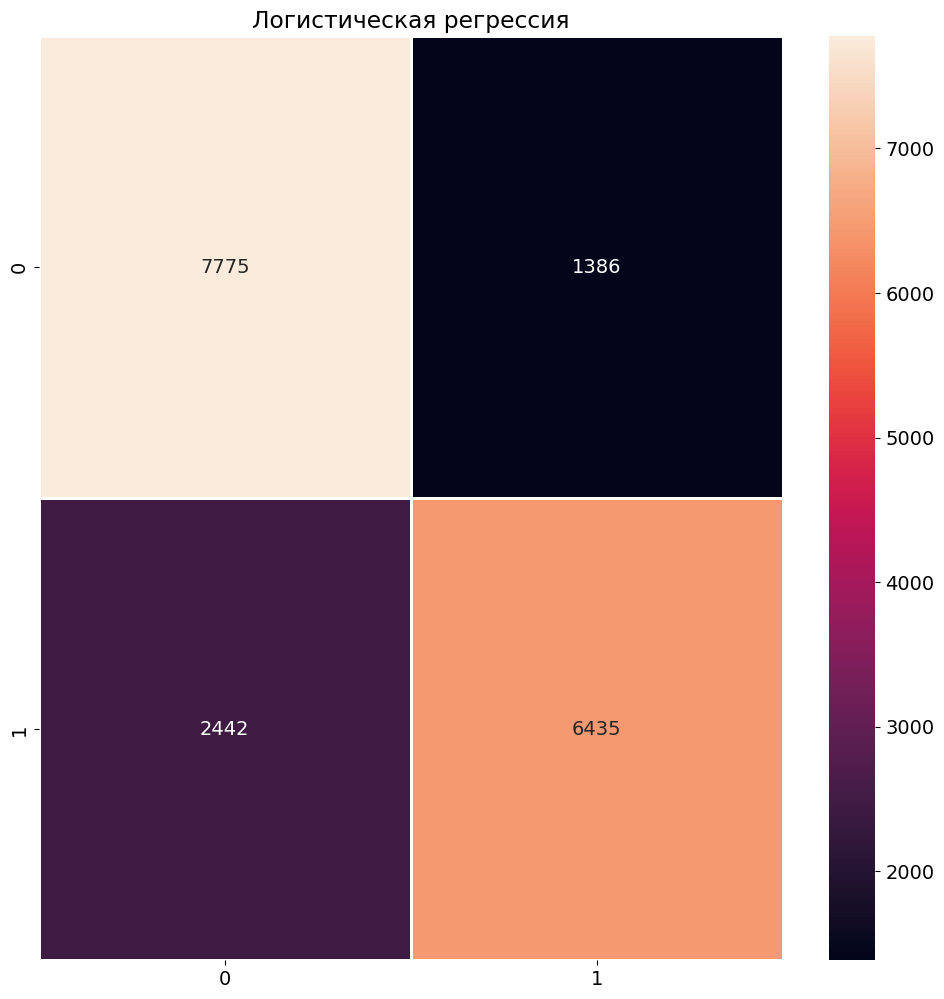

In [42]:

lr = LogisticRegression()
lr.fit(x_train_balanced, y_train_balanced)

y_pred = lr.predict(x_test_balanced)
classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Логистическая регрессия')

In [43]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.7878 
    Precision:0.8228
    Recall:0.7249
    F1: 0.7708
    AUC: 0.7868
    
    


In [44]:
# param_grid = {
#     'C': [0.01, 0.1, 1.0, 10.0, 20.0, 30.0],  
#     'tol':[0.0001, 0.001, 0.01, 0.1],
#     'penalty': ['l1', 'l2'],                    
# }

# grid_search = GridSearchCV(
#     estimator=cuml.LogisticRegression(),
#     param_grid=param_grid,
#     scoring='accuracy',           # Метрика для оценки
#     cv=5,                         # Количество фолдов для кросс-валидации
#     verbose=2,                    # Уровень детализации вывода
#     n_jobs=-1                     # Использование всех доступных ядер CPU
# )

# grid_search.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

# # Вывод лучших параметров и соответствующей точности
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшая точность на кросс-валидации:", grid_search.best_score_)
# best_model = grid_search.best_estimator_


In [45]:
# y_pred = best_model.predict(x_test_balanced)

In [46]:
# classification_report(y_test_balanced, y_pred)
# show_confusion_matrix(y_test_balanced, y_pred, 'LogisticRegression с подбором параметров')

In [47]:
# show_classification_report(y_test_balanced, y_pred)

## Random Forest

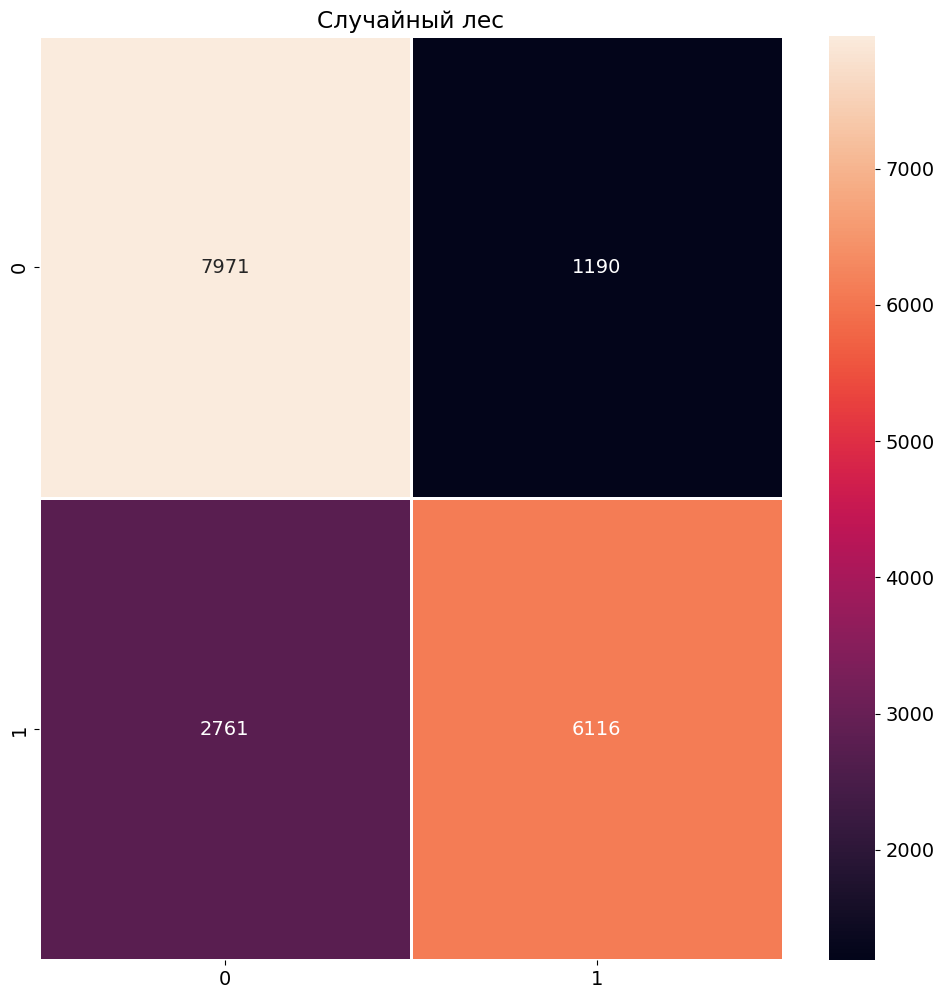

In [48]:
from cuml.ensemble import RandomForestClassifier 

rf = RandomForestClassifier()

rf.fit(x_train_balanced, y_train_balanced)

y_pred = rf.predict(x_test_balanced)
# classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Случайный лес')


In [49]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.7810 
    Precision:0.8371
    Recall:0.6890
    F1: 0.7559
    AUC: 0.7795
    
    


In [50]:
# param_grid = {
#     'n_estimators': [100, 150, 250, 300],  
#     'split_criterion':[0,1],
#     'max_depth': [16, 32, 64],
#     'max_leaves':[2,4,8,16,32]
# }

# grid_search = GridSearchCV(
#     estimator=cuml.RandomForestClassifier(),
#     param_grid=param_grid,
#     scoring='accuracy',           # Метрика для оценки
#     cv=3,                         # Количество фолдов для кросс-валидации
#     verbose=1,                    # Уровень детализации вывода
#     n_jobs=-1                     # Использование всех доступных ядер CPU
# )

# grid_search.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

# # Вывод лучших параметров и соответствующей точности
# print("Лучшие параметры:", grid_search.best_params_)
# print("Лучшая точность на кросс-валидации:", grid_search.best_score_)
# best_model = grid_search.best_estimator_

In [51]:
# y_pred = best_model.predict(x_test_balanced)
# classification_report(y_test_balanced, y_pred)
# show_confusion_matrix(y_test_balanced, y_pred, 'RandomForest')

## SVM

SVM:


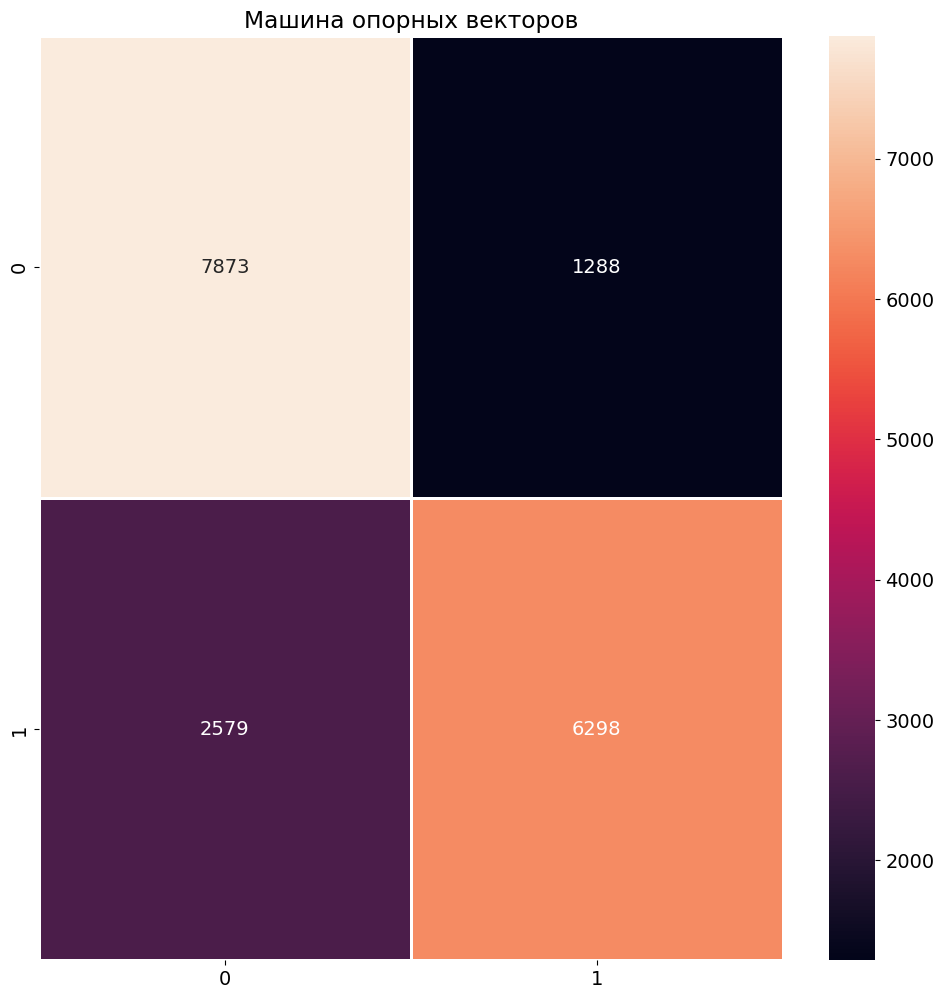

In [52]:
from cuml.svm import LinearSVC

svc = LinearSVC()

svc.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())

y_pred = svc.predict(x_test_balanced)
print('SVM:')
# classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Машина опорных векторов')


In [53]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.7856 
    Precision:0.8302
    Recall:0.7095
    F1: 0.7651
    AUC: 0.7844
    
    


## MBSGDClassifier

In [54]:
from cuml import MBSGDClassifier

mbsgd = MBSGDClassifier()

mbsgd.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())

MBSGDClassifier()

MBSGDClassifier:


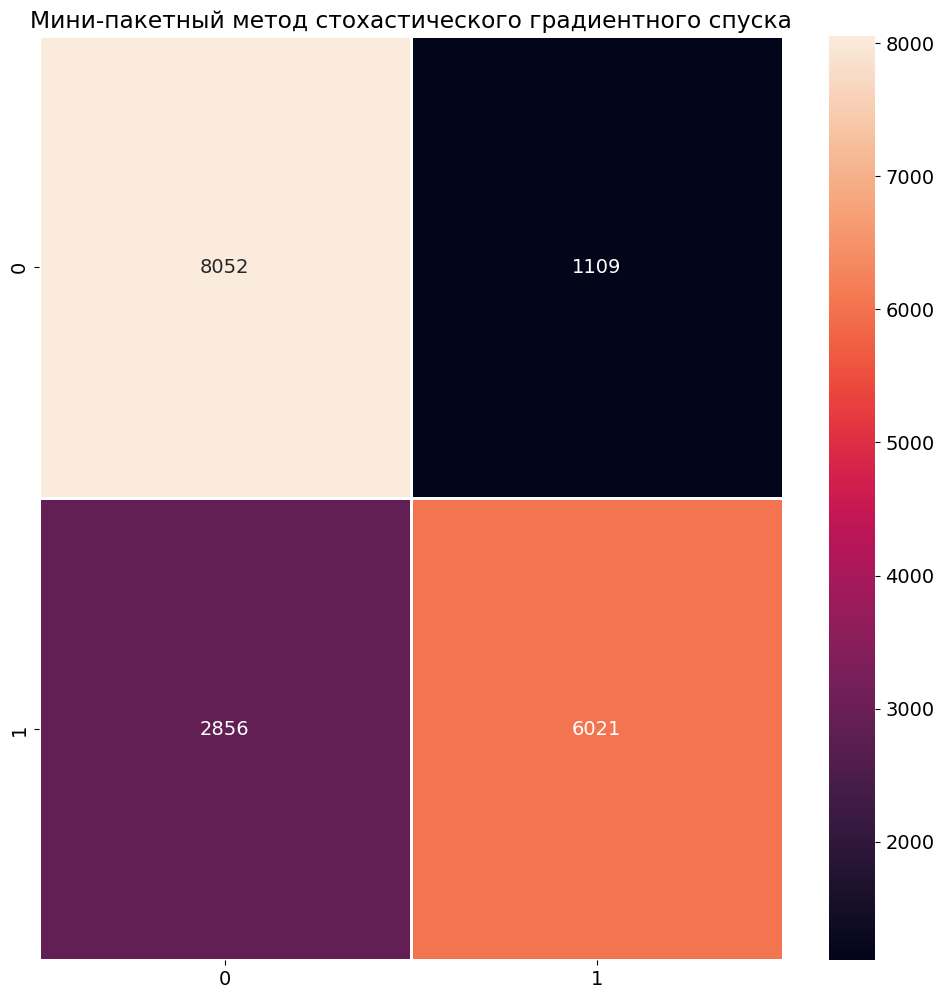

In [55]:
y_pred = mbsgd.predict(x_test_balanced)
print('MBSGDClassifier:')

# classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Мини-пакетный метод стохастического градиентного спуска')

In [56]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.7802 
    Precision:0.8445
    Recall:0.6783
    F1: 0.7523
    AUC: 0.7786
    
    


## Naive Bayes

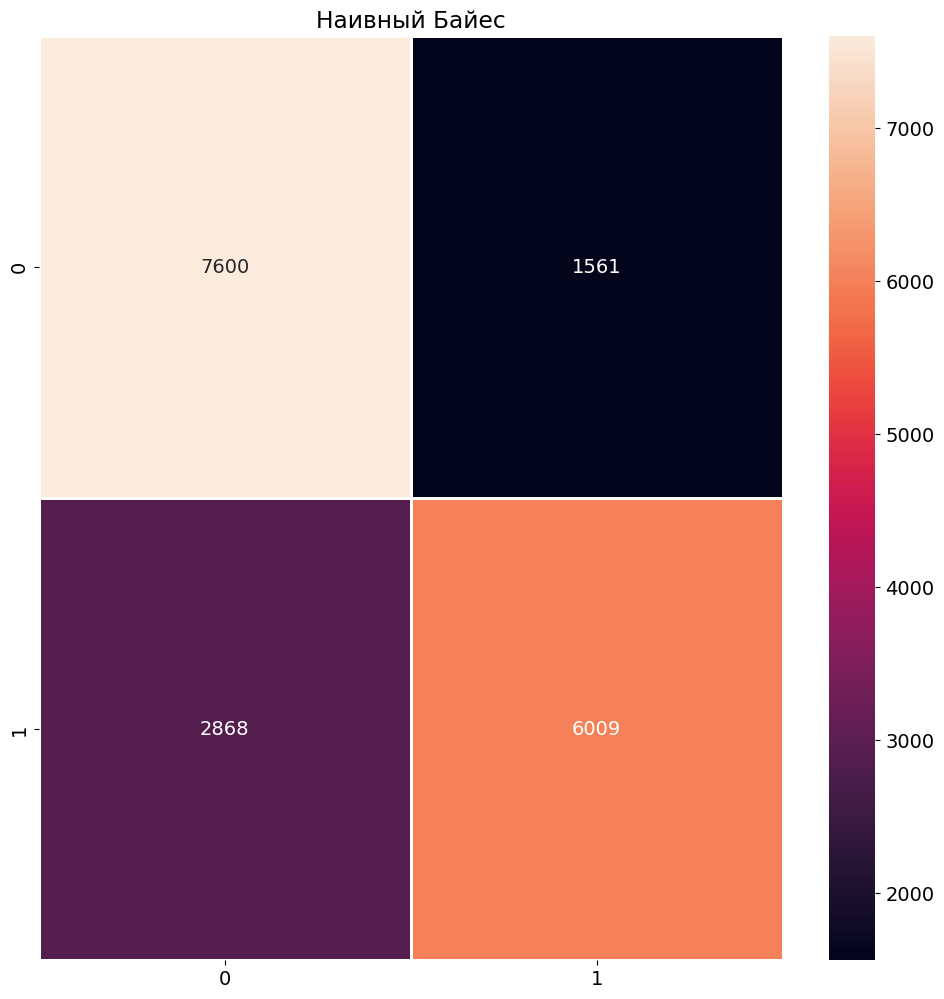

In [57]:
from cuml.naive_bayes import ComplementNB

nb = ComplementNB()

nb.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())
y_pred = nb.predict(x_test_balanced.to_cupy())

# classification_report(y_test_balanced.to_cupy(), y_pred)
show_confusion_matrix(y_test_balanced.to_cupy(), y_pred, 'Наивный Байес')

In [58]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.7545 
    Precision:0.7938
    Recall:0.6769
    F1: 0.7307
    AUC: 0.7533
    
    


## KNeighborsClassifier

KNN:


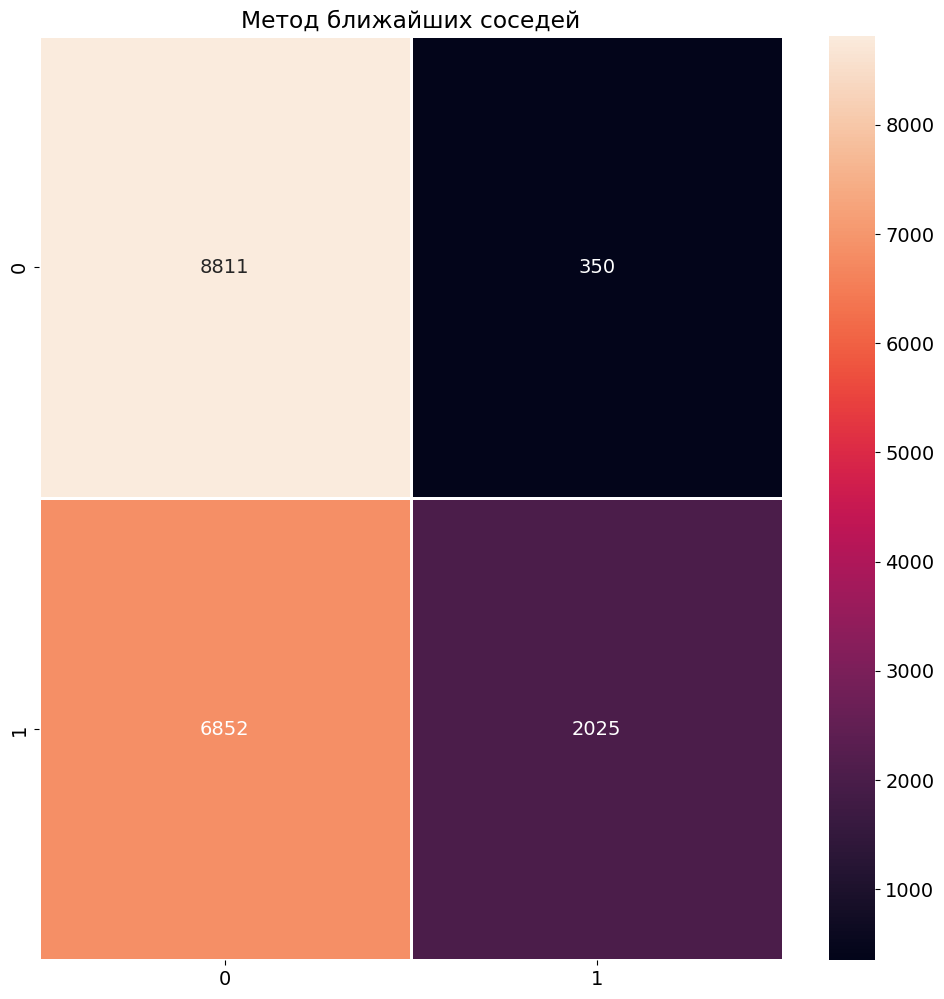

In [59]:
from cuml.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train_balanced.to_cupy(), y_train_balanced.to_cupy())
y_pred = knn.predict(x_test_balanced)
print('KNN:')

# classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Метод ближайших соседей')

In [60]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.6007 
    Precision:0.8526
    Recall:0.2281
    F1: 0.3599
    AUC: 0.5950
    
    


## Voting классификатор

In [61]:
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(
    estimators=[
        ('lr', lr),
        ('rf', rf),
        # ('svc', svc),
        ('mbsdg', mbsgd),
        ('nb', nb),
        # ('knn', knn)
    ],
    voting='hard' 
)

In [62]:
voting_clf.fit(x_train_balanced.to_cupy().get(), y_train_balanced.to_cupy().get())

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()),
                             ('mbsdg', MBSGDClassifier()),
                             ('nb', ComplementNB())])

In [63]:
# print("Тип данных для LR:", lr.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для RF:", rf.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для SVC:", svc.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для MBSGD:", mbsgd.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для NB:", nb.predict(review_vector_test.todense().get()).dtype)
# print("Тип данных для KNN:", knn.predict(review_vector_test.todense().get()).dtype)

Voting classifier:


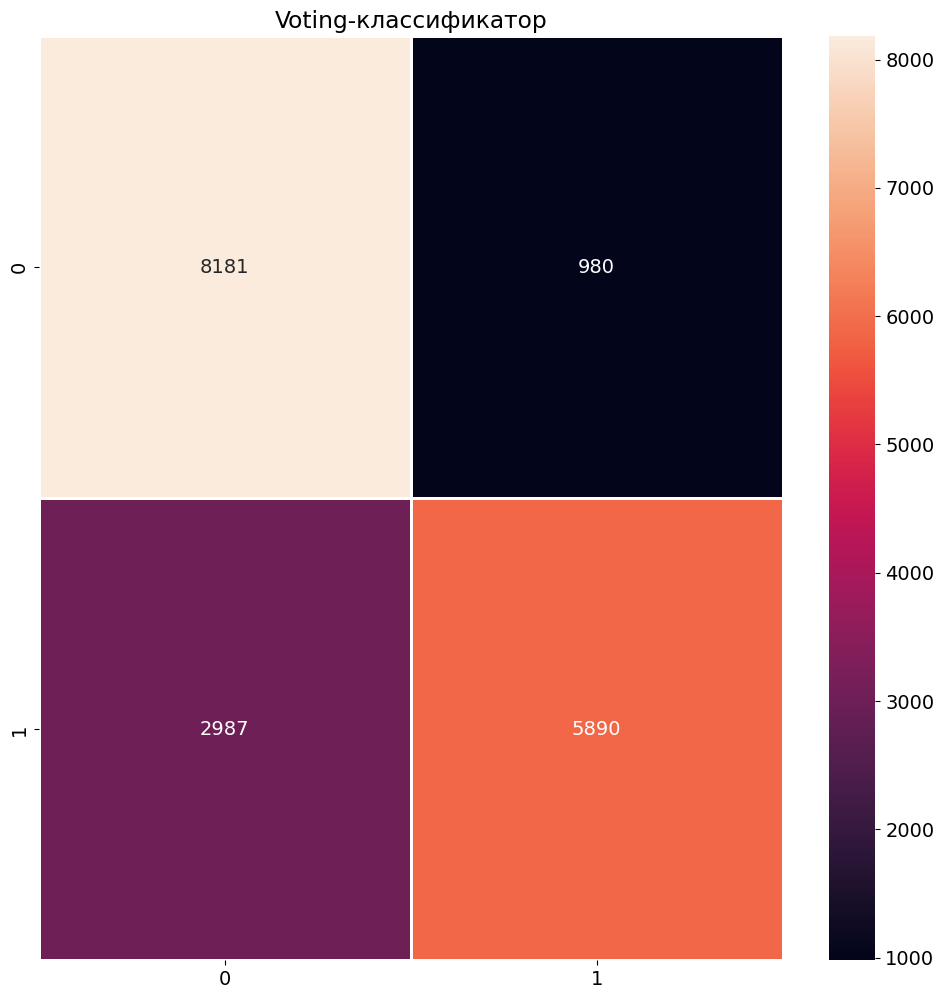

In [64]:
y_pred = voting_clf.predict(x_test_balanced.to_cupy().get())
print('Voting classifier:')
# classification_report(y_test_balanced, y_pred)
show_confusion_matrix(y_test_balanced, y_pred, 'Voting-классификатор')

In [65]:
show_classification_report(y_test_balanced, y_pred)


    Accuracy:0.7801 
    Precision:0.8574
    Recall:0.6635
    F1: 0.7481
    AUC: 0.7783
    
    


# Сохранение сбалансированного датасета в файл

## TF-IDF векторы 

In [66]:
x_balanced.shape, y_balanced.shape

((72155, 1000), (72155,))

In [67]:
y_balanced.value_counts()

label
0    36846
1    35309
Name: count, dtype: int64

In [68]:
x_balanced.to_csv('yelp_nyc_X_tf_idf_balanced.csv')

In [69]:
cudf.DataFrame(y_balanced)

,label
352981,1
24713,1
240729,1
317219,1
75605,1
...,...
358478,0
358479,0
358639,0
358640,0


In [70]:
cudf.DataFrame(y_balanced).to_csv('yelp_nyc_y_labels_balanced.csv')

## Выборка из исходного датафрейма

In [71]:
balanced_origin_df = df_origin.loc[df_indices]
balanced_origin_df

,Unnamed: 0,user_id,prod_id,review,rating,label,prod_name,date,avg_prod_rating,avg_user_rating,review_len,cnt_reviews,neg,neu,pos,compound,cap_words,digit_words
352981,352981,87962,247,Such a long wait (an hour even in the late aft...,5.0,1,Ippudo NY,2009-05-03,4.07,4.50,246,2,0.000,0.725,0.275,0.9330,0,0
24713,24713,20860,72,What it says on the tin - a ramen bar that's h...,4.0,1,Totto Ramen,2014-09-03,3.97,4.00,464,1,0.026,0.780,0.194,0.9549,0,1
240729,240729,123551,632,I had their pepperoni pizza. It wasn't very go...,1.0,1,Patzeria Perfect Pizza,2013-11-05,4.00,1.00,277,1,0.090,0.786,0.124,0.4582,0,0
317219,317219,148462,837,Food is delish. Place gets packed. Wine list i...,4.0,1,Uva,2010-04-11,4.09,3.50,462,2,0.016,0.796,0.188,0.9467,2,0
75605,75605,52348,211,All my coworkers rave about this place. We are...,3.0,1,Artichoke Basille’s Pizza,2013-10-04,3.89,3.50,1132,6,0.053,0.791,0.156,0.9730,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260855,260855,38543,672,This is my Cafe Luluc of Manhattan. Great ser...,5.0,1,Café Orlin,2011-06-29,4.02,3.84,300,44,0.048,0.791,0.161,0.7384,0,0
191286,191286,103763,521,I have been a NYer my whole life. This is so f...,5.0,1,Di Fara Pizza,2014-07-29,4.13,5.00,292,1,0.033,0.745,0.223,0.9145,0,0
263840,263840,31396,684,Went here for lunch on a weekend. Waited about...,4.0,1,Taverna Kyclades,2013-12-22,4.19,4.00,408,4,0.015,0.771,0.214,0.9539,0,1
191289,191289,2126,521,"Hands down, my favorite pizza in America! My m...",5.0,1,Di Fara Pizza,2014-07-24,4.13,4.50,241,30,0.054,0.750,0.196,0.7494,0,0


In [72]:
balanced_origin_df['label'].value_counts()

label
1    35309
Name: count, dtype: int64

In [73]:
origin_fake = df_origin[df_origin['label'] == -1]

In [74]:
balanced_origin_df=  cudf.concat([balanced_origin_df, origin_fake], axis=0)
balanced_origin_df

,Unnamed: 0,user_id,prod_id,review,rating,label,prod_name,date,avg_prod_rating,avg_user_rating,review_len,cnt_reviews,neg,neu,pos,compound,cap_words,digit_words
352981,352981,87962,247,Such a long wait (an hour even in the late aft...,5.0,1,Ippudo NY,2009-05-03,4.07,4.5,246,2,0.000,0.725,0.275,0.9330,0,0
24713,24713,20860,72,What it says on the tin - a ramen bar that's h...,4.0,1,Totto Ramen,2014-09-03,3.97,4.0,464,1,0.026,0.780,0.194,0.9549,0,1
240729,240729,123551,632,I had their pepperoni pizza. It wasn't very go...,1.0,1,Patzeria Perfect Pizza,2013-11-05,4.00,1.0,277,1,0.090,0.786,0.124,0.4582,0,0
317219,317219,148462,837,Food is delish. Place gets packed. Wine list i...,4.0,1,Uva,2010-04-11,4.09,3.5,462,2,0.016,0.796,0.188,0.9467,2,0
75605,75605,52348,211,All my coworkers rave about this place. We are...,3.0,1,Artichoke Basille’s Pizza,2013-10-04,3.89,3.5,1132,6,0.053,0.791,0.156,0.9730,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358478,358478,161046,921,Bijan is the best bar I have been to in Brookl...,5.0,-1,Bijan’s,2011-12-01,4.17,5.0,244,1,0.055,0.797,0.148,0.6352,0,0
358479,358479,161047,921,Great local lounge spot! After work and regula...,5.0,-1,Bijan’s,2011-11-15,4.17,5.0,169,1,0.000,0.546,0.454,0.9600,0,0
358639,358639,161111,349,First and last time we try this place. Pizza ...,1.0,-1,Emily,2014-03-25,4.19,1.0,866,1,0.079,0.822,0.099,0.4848,6,0
358640,358640,161112,349,"The staff was incredibly nice, the lemonade ta...",3.0,-1,Emily,2014-04-09,4.19,3.0,398,1,0.000,0.834,0.166,0.8460,1,0


In [75]:
balanced_origin_df.to_csv('yelp_nyc_kmeans_balancing.csv')